In [3]:
import mne

data = mne.io.read_raw_eeglab("../data/example/sub-PIB00038_rs-HEP_eeg.set")
data.plot()

In [18]:
# General imports
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm, colors, colorbar

# Import MNE, as well as the MNE sample dataset
import mne
from mne.datasets import sample

# FOOOF imports
from fooof import FOOOFGroup
from fooof.bands import Bands
from fooof.analysis import get_band_peak_fg
from fooof.plts.spectra import plot_spectra

[WARNING] /var/folders/xq/sl7xjp_95qx7wfngy6s6vvg00000gn/T/ipykernel_44631/3827075834.py:11: DeprecationWarning: 
The `fooof` package is being deprecated and replaced by the `specparam` (spectral parameterization) package.
This version of `fooof` (1.1) is fully functional, but will not be further updated.
New projects are recommended to update to using `specparam` (see Changelog for details).
  from fooof import FOOOFGroup



In [31]:
def check_nans(data, nan_policy="zero"):
    """Check an array for nan values, and replace, based on policy."""

    # Find where there are nan values in the data
    nan_inds = np.where(np.isnan(data))

    # Apply desired nan policy to data
    if nan_policy == "zero":
        data[nan_inds] = 0
    elif nan_policy == "mean":
        data[nan_inds] = np.nanmean(data)
    else:
        raise ValueError("Nan policy not understood.")

    return data

In [20]:
raw = data
raw = raw.pick(["eeg"], exclude="bads")

In [21]:
raw = raw.set_eeg_reference()

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


In [23]:
# Calculate power spectra across the continuous data
psd = raw.compute_psd(method="welch", fmin=1, fmax=40)
spectra, freqs = psd.get_data(return_freqs=True)

Effective window size : 4.000 (s)


In [24]:
# Initialize a FOOOFGroup object, with desired settings
fg = FOOOFGroup(
    peak_width_limits=[1, 6],
    min_peak_height=0.15,
    peak_threshold=2.0,
    max_n_peaks=6,
    verbose=False,
)

# Define the frequency range to fit
freq_range = [1, 30]

In [25]:
# Fit the power spectrum model across all channels
fg.fit(freqs, spectra, freq_range)

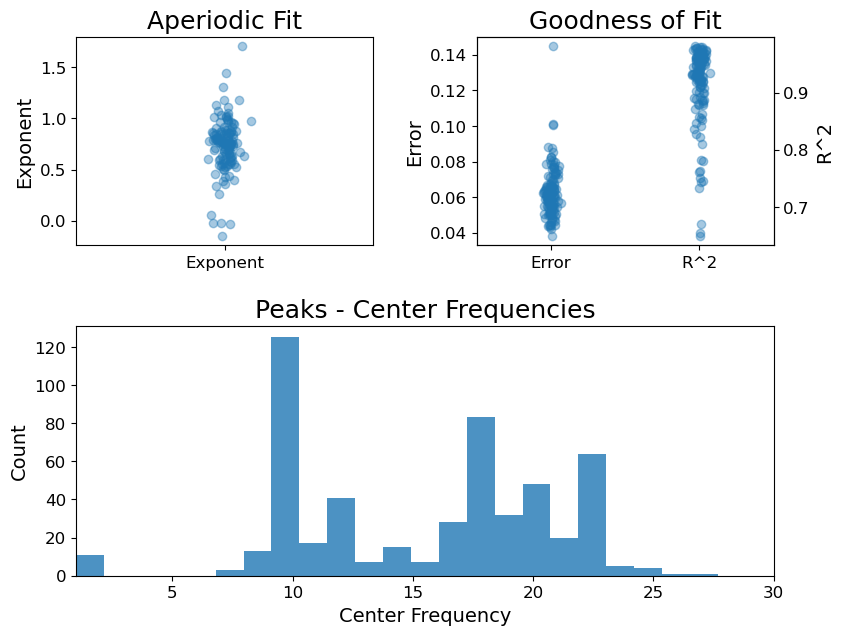

In [26]:
# Check the overall results of the group fits
fg.plot()

In [33]:
# Define frequency bands of interest
bands = Bands({"theta": [3, 7], "alpha": [7, 14], "beta": [15, 30]})

In [34]:
# Extract alpha peaks
alphas = get_band_peak_fg(fg, bands.alpha)

# Extract the power values from the detected peaks
alpha_pw = alphas[:, 1]

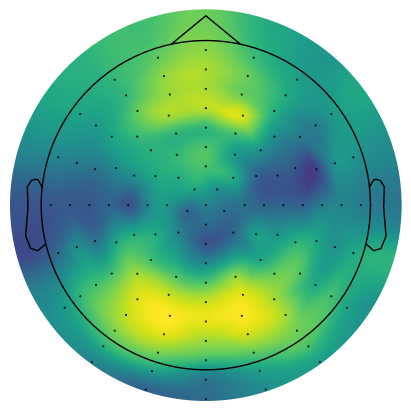

(<matplotlib.image.AxesImage at 0x2a0196690>, None)

In [35]:
# Plot the topography of alpha power
mne.viz.plot_topomap(alpha_pw, raw.info, cmap=cm.viridis, contours=0, size=4)

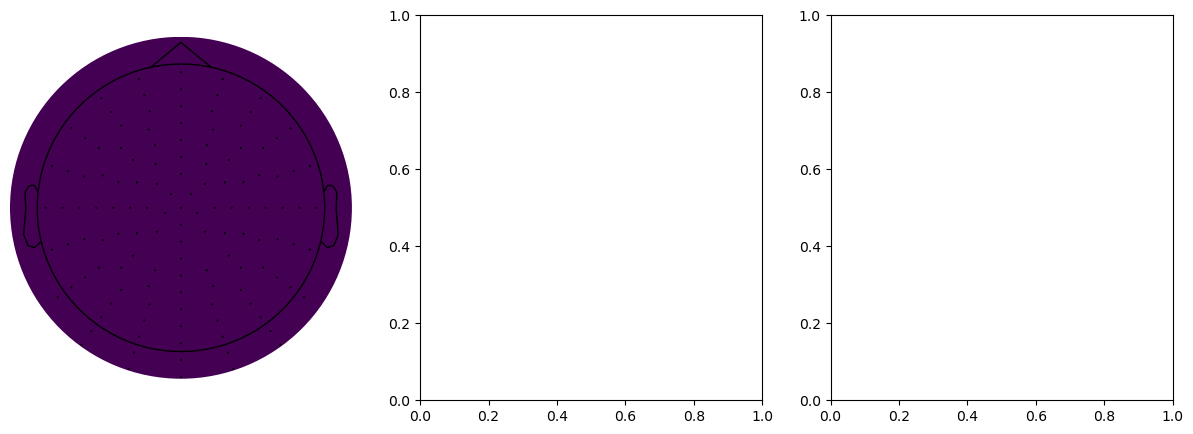

In [36]:
# Plot the topographies across different frequency bands
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for ind, (label, band_def) in enumerate(bands):
    # Get the power values across channels for the current band
    band_power = check_nans(get_band_peak_fg(fg, band_def)[:, 1])

    # Create a topomap for the current oscillation band
    mne.viz.plot_topomap(
        band_power, raw.info, cmap=cm.viridis, contours=0, axes=axes[ind]
    )

    # Set the plot title
    axes[ind].set_title(label + " power", {"fontsize": 20})

In [42]:
# Calculate power spectra across the continuous data
psd = raw.compute_psd(method="welch", fmin=1, fmax=40)
spectra, freqs = psd.get_data(return_freqs=True)

Effective window size : 4.000 (s)


In [43]:
# Initialize a FOOOFGroup object, with desired settings
fg = FOOOFGroup(
    peak_width_limits=[1, 6],
    min_peak_height=0.15,
    peak_threshold=2.0,
    max_n_peaks=6,
    verbose=False,
)

# Define the frequency range to fit
freq_range = [1, 40]

In [44]:
# Fit the power spectrum model across all channels
fg.fit(freqs, spectra, freq_range)

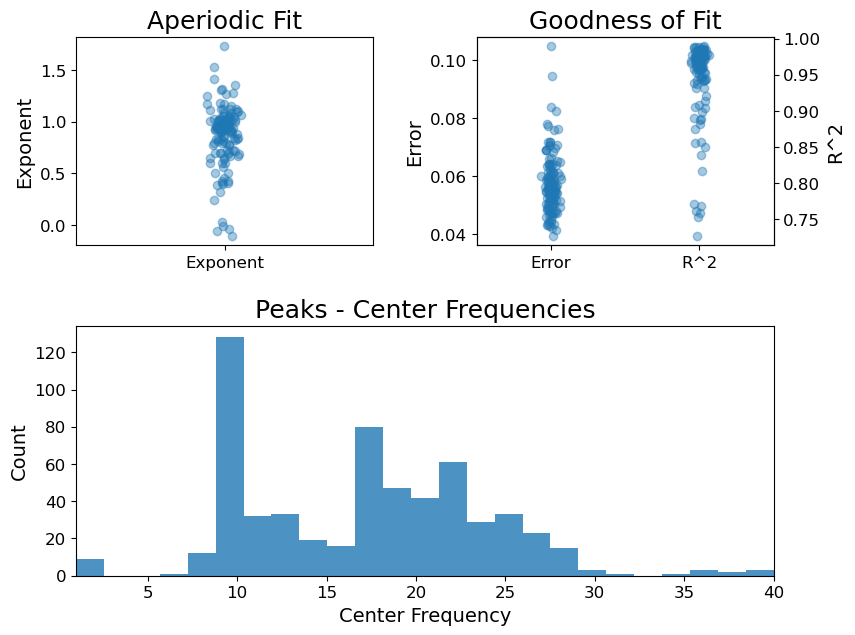

In [45]:
# Check the overall results of the group fits
fg.plot()

In [46]:
# Define frequency bands of interest
bands = Bands({"theta": [3, 7], "alpha": [7, 14], "beta": [15, 30]})

In [47]:
# Extract alpha peaks
alphas = get_band_peak_fg(fg, bands.alpha)

# Extract the power values from the detected peaks
alpha_pw = alphas[:, 1]

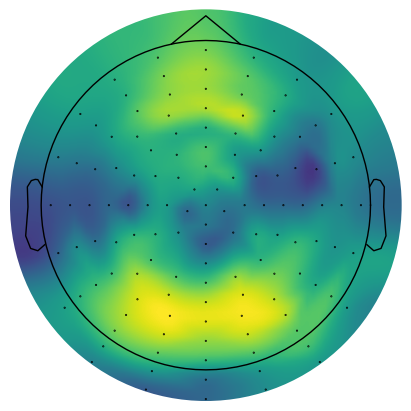

(<matplotlib.image.AxesImage at 0x2a070f0d0>, None)

In [48]:
mne.viz.plot_topomap(alpha_pw, raw.info, cmap=cm.viridis, contours=0, size=4)

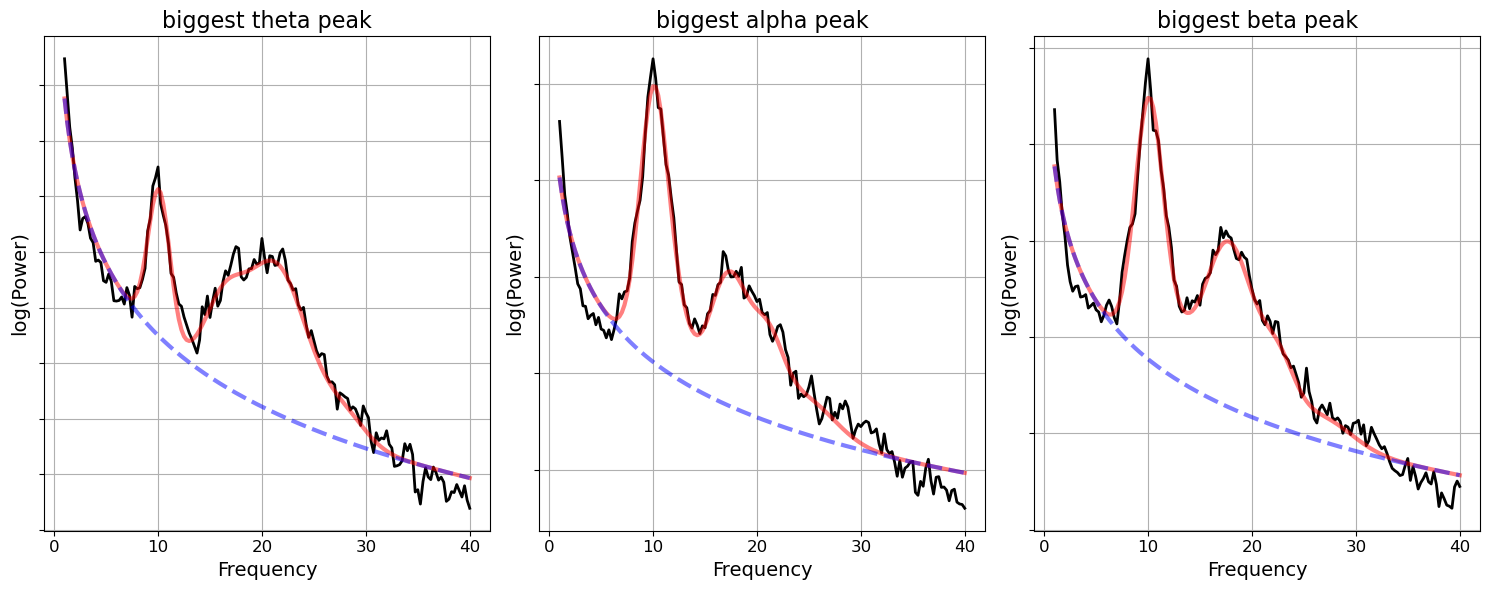

In [50]:
fig, axes = plt.subplots(1, 3, figsize=(15, 6))
for ind, (label, band_def) in enumerate(bands):
    # Get the power values across channels for the current band
    band_power = check_nans(get_band_peak_fg(fg, band_def)[:, 1])

    # Extracted and plot the power spectrum model with the most band power
    fg.get_fooof(np.argmax(band_power)).plot(ax=axes[ind], add_legend=False)

    # Set some plot aesthetics & plot title
    axes[ind].yaxis.set_ticklabels([])
    axes[ind].set_title("biggest " + label + " peak", {"fontsize": 16})

In [57]:
# Extract aperiodic exponent values
exps = fg.get_params("aperiodic_params", "exponent")

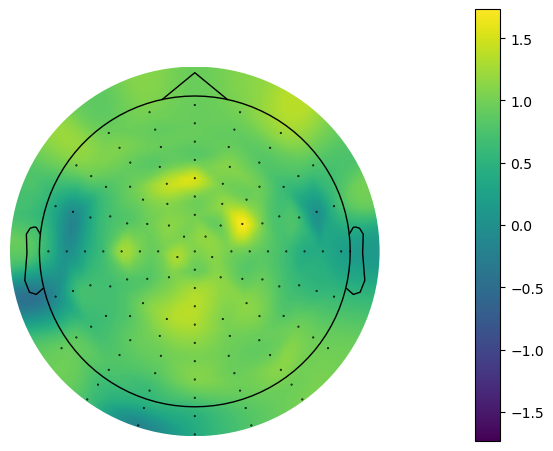

In [64]:
import matplotlib.pyplot as plt
import mne  # Make sure you have the MNE library installed

# Assuming 'exps' is your data array and 'raw' is an MNE raw object
# Also, assuming 'unit_label' and 'fontsize' variables are defined

fig, ax = plt.subplots()

# The 'cmap' parameter expects a colormap object, not a string
im, _ = mne.viz.plot_topomap(
    exps, raw.info, axes=ax, cmap="viridis", contours=0, show=False
)

# Colorbar setup
ax_x_start = 0.95
ax_x_width = 0.04
ax_y_start = 0.1
ax_y_height = 0.9
cbar_ax = fig.add_axes([ax_x_start, ax_y_start, ax_x_width, ax_y_height])
fig.colorbar(im, cax=cbar_ax)

plt.show()

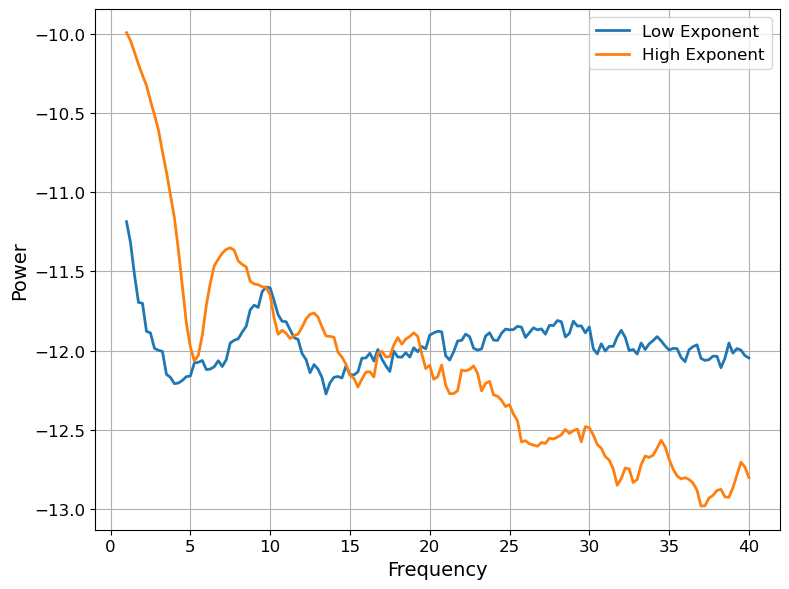

In [53]:
# Compare the power spectra between low and high exponent channels
fig, ax = plt.subplots(figsize=(8, 6))

spectra = [
    fg.get_fooof(np.argmin(exps)).power_spectrum,
    fg.get_fooof(np.argmax(exps)).power_spectrum,
]

plot_spectra(fg.freqs, spectra, ax=ax, labels=[
             "Low Exponent", "High Exponent"])

I just sampled
Condition where I found the data

- 1-AD
- 2-bvFTD - behavioral variant frontotemporal dementia (bvFT?D
- healthy control

Doesnt have ofyen
3-PD
4-MS
